Episode 1, Reward: -1251.31
Episode 2, Reward: -1147.41
Episode 3, Reward: -1635.51
Episode 4, Reward: -1143.68
Episode 5, Reward: -1706.35
Episode 6, Reward: -1594.64
Episode 7, Reward: -1599.20
Episode 8, Reward: -1564.54
Episode 9, Reward: -1546.84
Episode 10, Reward: -1530.40
Episode 11, Reward: -1439.57
Episode 12, Reward: -1747.25
Episode 13, Reward: -1611.84
Episode 14, Reward: -1558.18
Episode 15, Reward: -1623.57
Episode 16, Reward: -1758.91
Episode 17, Reward: -1648.55
Episode 18, Reward: -1602.50
Episode 19, Reward: -1479.50
Episode 20, Reward: -1503.90
Episode 21, Reward: -1499.34
Episode 22, Reward: -1531.90
Episode 23, Reward: -1502.89
Episode 24, Reward: -1515.04
Episode 25, Reward: -1552.02
Episode 26, Reward: -1518.06
Episode 27, Reward: -1792.82
Episode 28, Reward: -1400.19
Episode 29, Reward: -1501.45
Episode 30, Reward: -1442.00
Episode 31, Reward: -1649.49
Episode 32, Reward: -1492.30
Episode 33, Reward: -1638.74
Episode 34, Reward: -1495.52
Episode 35, Reward: -15

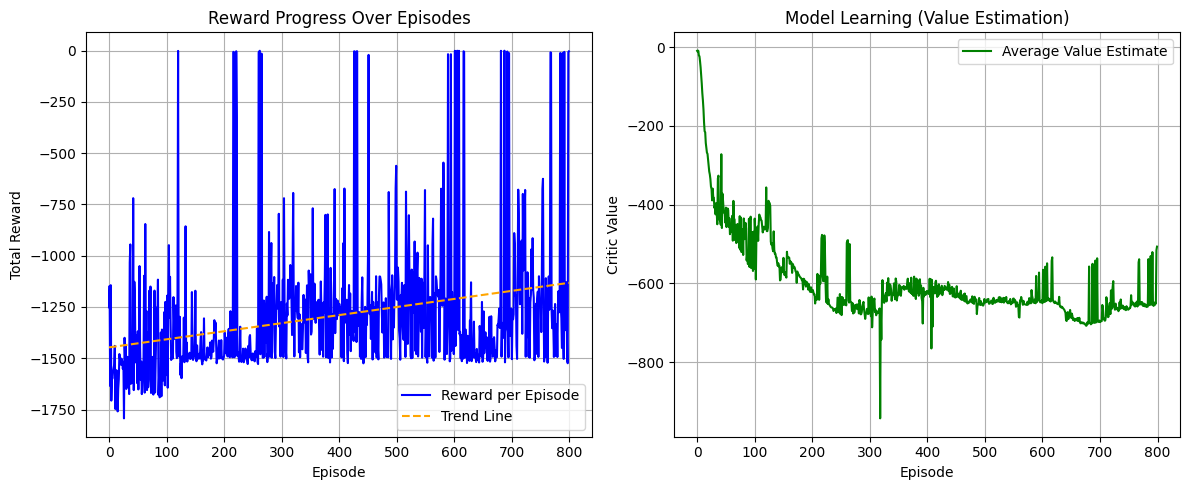

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to pendulum_simulation.mp4
Total reward in video episode: -4.71


python(21242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [7]:
# import numpy as np
# if not hasattr(np, 'bool8'):
#     np.bool8 = np.bool_
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# Hyperparameters
GAMMA = 0.995
LR = 0.0003
EPISODES = 800
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
        )
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))  # learnable std
        self.value = nn.Linear(256, 1)

    def forward(self, x):
        x = self.shared(x)
        mean = self.mean(x)
        std = self.log_std.exp().expand_as(mean)
        value = self.value(x)
        return mean, std, value

def train():
    env = gym.make('Pendulum-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    model = ActorCritic(state_dim, action_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    rewards_per_episode = []
    value_estimates = []

    for episode in range(EPISODES):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        done = False
        episode_reward = 0
        episode_values = []

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            mean, std, value = model(state_tensor)

            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)

            # Clip action to env limits [-2, 2]
            action_clamped = torch.clamp(action, -2.0, 2.0)
            step_result = env.step(action_clamped.squeeze(0).cpu().detach().numpy())

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(DEVICE)
            _, _, next_value = model(next_state_tensor)

            td_target = reward + GAMMA * next_value.item() * (1 - int(done))
            advantage = td_target - value.item()

            actor_loss = -log_prob * advantage
            critic_loss = (td_target - value) ** 2
            loss = actor_loss + critic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            episode_reward += reward
            episode_values.append(value.item())

        print(f"Episode {episode + 1}, Reward: {episode_reward:.2f}")
        rewards_per_episode.append(episode_reward)
        value_estimates.append(np.mean(episode_values))

    env.close()

    # Plot rewards with trend line
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode, label="Reward per Episode", color='blue')
    z = np.polyfit(range(len(rewards_per_episode)), rewards_per_episode, 1)
    trend = np.poly1d(z)
    plt.plot(trend(range(len(rewards_per_episode))), "--", label="Trend Line", color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Progress Over Episodes")
    plt.legend()
    plt.grid(True)

    # Plot average value estimate per episode
    plt.subplot(1, 2, 2)
    plt.plot(value_estimates, label="Average Value Estimate", color='green')
    plt.xlabel("Episode")
    plt.ylabel("Critic Value")
    plt.title("Model Learning (Value Estimation)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model  # return trained model for video generation
# return trained model for video generation

def generate_video(model):
    env = gym.make("Pendulum-v1", render_mode="rgb_array")
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

    done = False
    frames = []
    episode_reward = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        mean, std, value = model(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        action_clipped = torch.clamp(action, -2.0, 2.0)

        # Get frame BEFORE calling step — this is how gym>=0.26 works with rgb_array mode
        frames.append(env.render())

        step_result = env.step(action_clipped.squeeze(0).cpu().detach().numpy())

        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result

        state = next_state
        episode_reward += reward

    env.close()

    video_path = "pendulum_simulation.mp4"
    imageio.mimsave(video_path, frames, fps=30)
    print(f"Video saved to {video_path}")
    print(f"Total reward in video episode: {episode_reward:.2f}")

if __name__ == "__main__":
    trained_model = train()
    generate_video(trained_model)


/opt/homebrew/anaconda3/envs/learning/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/opt/homebrew/anaconda3/envs/learning/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
/var/folders/f3/fnztj0dx7v58nbvbmkwh7df80000gn/T/ipykernel_1666/3561025566.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ep_reward = float(sum(rewards))  # force float conversion


Episode 0, Return: -1446.13
Episode 1, Return: -1230.71
Episode 2, Return: -1687.19
Episode 3, Return: -1515.87
Episode 4, Return: -1498.52
Episode 5, Return: -1336.76
Episode 6, Return: -1445.15
Episode 7, Return: -1651.94
Episode 8, Return: -1367.48
Episode 9, Return: -1726.06
Episode 10, Return: -1353.51
Episode 11, Return: -1157.76
Episode 12, Return: -1104.26
Episode 13, Return: -1545.06
Episode 14, Return: -1712.16
Episode 15, Return: -1294.19
Episode 16, Return: -1456.44
Episode 17, Return: -1699.80
Episode 18, Return: -1408.49
Episode 19, Return: -1181.53
Episode 20, Return: -1512.59
Episode 21, Return: -1065.76
Episode 22, Return: -960.90
Episode 23, Return: -1045.54
Episode 24, Return: -1340.56
Episode 25, Return: -1307.81
Episode 26, Return: -1555.67
Episode 27, Return: -1545.61
Episode 28, Return: -1111.95
Episode 29, Return: -1535.66
Episode 30, Return: -1284.48
Episode 31, Return: -1255.99
Episode 32, Return: -1497.32
Episode 33, Return: -1071.11
Episode 34, Return: -1166

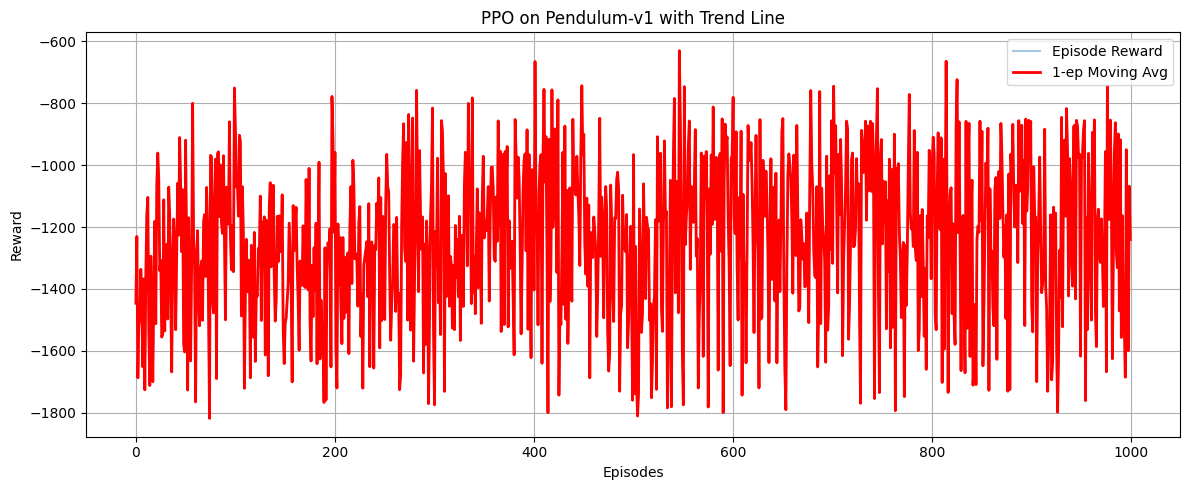

reward sum -1245393.2611572982


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


🎥 Video saved as ppo_pendulum_video.mp4


python(21674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [27]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Hyperparameters
GAMMA = 0.75
LR = 0.0003
CLIP_EPS = 0.3
EPOCHS = 4
EPISODES = 1000
ENTROPY_COEF = 0.001

# PPO Actor-Critic Network for continuous action space
class PPOActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPOActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.actor_mean = nn.Linear(128, action_dim)
        self.actor_log_std = nn.Parameter(torch.zeros(action_dim))
        self.critic = nn.Linear(128, 1)

    def forward(self, state):
        x = self.common(state)
        mean = self.actor_mean(x)
        std = torch.exp(self.actor_log_std)
        value = self.critic(x)
        return mean, std, value

# Collect one full trajectory from env
def collect_trajectory(env, model, max_steps=200):
    states, actions, log_probs, rewards, values = [], [], [], [], []
    state, _ = env.reset()
    done = False
    steps = 0

    while not done and steps < max_steps:
        state_tensor = torch.FloatTensor(np.array(state)).view(1, -1)
        mean, std, value = model(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)

        clipped_action = np.clip(action.detach().numpy(), -2.0, 2.0)  # Pendulum max torque = 2.0
        next_state, reward, terminated, truncated, _ = env.step(clipped_action)
        done = terminated or truncated

        states.append(state_tensor.squeeze(0))
        actions.append(torch.FloatTensor(clipped_action))
        log_probs.append(log_prob)
        rewards.append(reward)
        values.append(value.squeeze())

        state = next_state
        steps += 1

    return states, actions, log_probs, rewards, values

# Compute return and advantage
def compute_advantages(rewards, values, gamma=GAMMA):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32)
    values_tensor = torch.stack(values)
    advantages = returns - values_tensor.detach()
    return returns.detach(), advantages.detach()

# PPO update
def ppo_update(model, optimizer, states, actions, old_log_probs, returns, advantages):
    states = torch.stack(states)
    actions = torch.stack(actions)
    old_log_probs = torch.stack(old_log_probs)

    for _ in range(EPOCHS):
        mean, std, values = model(states)
        dist = torch.distributions.Normal(mean, std)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1).mean()

        ratio = torch.exp(new_log_probs - old_log_probs.detach())
        surrogate1 = ratio * advantages
        surrogate2 = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * advantages

        actor_loss = -torch.min(surrogate1, surrogate2).mean()
        critic_loss = (returns - values.squeeze()).pow(2).mean()
        loss = actor_loss + 0.5 * critic_loss - ENTROPY_COEF * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Training loop
# def train(env, model, optimizer, episodes):
#     reward_history = []

#     for ep in range(episodes):
#         states, actions, log_probs, rewards, values = collect_trajectory(env, model)
#         returns, advantages = compute_advantages(rewards, values)
#         ppo_update(model, optimizer, states, actions, log_probs, returns, advantages)

#         ep_reward = sum(rewards)
#         reward_history.append(ep_reward)

#         print(f"Episode {ep}, Return: {float(ep_reward):.2f}")

#     return reward_history
def train(env, model, optimizer, episodes):
    reward_history = []

    for ep in range(episodes):
        states, actions, log_probs, rewards, values = collect_trajectory(env, model)
        returns, advantages = compute_advantages(rewards, values)
        ppo_update(model, optimizer, states, actions, log_probs, returns, advantages)

        ep_reward = float(sum(rewards))  # force float conversion
        reward_history.append(ep_reward)

        print(f"Episode {ep}, Return: {ep_reward:.2f}")

    return reward_history


# Plot results
# def plot_rewards(reward_history):
#     plt.figure(figsize=(10, 5))
#     plt.plot(reward_history, label="Episode Reward")
#     plt.xlabel("Episodes")
#     plt.ylabel("Reward")
#     plt.title("PPO on Pendulum-v1")
#     plt.legend()
#     plt.grid()
#     plt.tight_layout()
#     plt.show()

# def plot_rewards(reward_history, window=20):
#     episodes = np.arange(len(reward_history))
#     rewards = np.array(reward_history)

#     # Moving average (trend line)
#     moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')

#     # Polynomial fit (optional alternative)
#     # z = np.polyfit(episodes, rewards, 3)
#     # p = np.poly1d(z)

#     plt.figure(figsize=(12, 5))
#     plt.plot(episodes, rewards, label="Episode Reward", alpha=0.4)
#     plt.plot(np.arange(window - 1, len(rewards)), moving_avg, label=f"{window}-ep Moving Avg", color="red", linewidth=2)
#     # plt.plot(episodes, p(episodes), label="Trend Line (Polyfit)", linestyle="--", color="green")

#     plt.xlabel("Episodes")
#     plt.ylabel("Reward")
#     plt.title("PPO on Pendulum-v1 with Trend Line")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

def plot_rewards(reward_history, window=1):
    episodes = np.arange(len(reward_history))
    rewards = np.array(reward_history, dtype=np.float32)

    if len(rewards) < window:
        print(f"⚠️ Not enough data to compute moving average (need at least {window} episodes).")
        moving_avg = rewards  # fallback
        moving_avg_x = episodes
    else:
        moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')
        moving_avg_x = np.arange(window - 1, len(rewards))

    plt.figure(figsize=(12, 5))
    plt.plot(episodes, rewards, label="Episode Reward", alpha=0.4)
    plt.plot(moving_avg_x, moving_avg, label=f"{window}-ep Moving Avg", color="red", linewidth=2)

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("PPO on Pendulum-v1 with Trend Line")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Save video of the agent
def record_video(env, model, filename="ppo_pendulum_video.mp4"):
    frames = []
    state, _ = env.reset()
    done = False
    while not done:
        state_tensor = torch.FloatTensor(np.array(state)).unsqueeze(0)
        mean, std, _ = model(state_tensor)
        action = mean.detach().numpy()[0]
        clipped_action = np.clip(action, -2.0, 2.0)
        state, _, terminated, truncated, _ = env.step(clipped_action)
        done = terminated or truncated
        frame = env.render()
        frames.append(frame)

    env.close()
    imageio.mimsave(filename, frames, fps=30)
    print(f"🎥 Video saved as {filename}")

# Main script
env = gym.make("Pendulum-v1", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

model = PPOActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=LR)

reward_history = train(env, model, optimizer, EPISODES)
torch.save(model.state_dict(), "ppo_pendulum.pth")
print("✅ Model saved as ppo_pendulum.pth")

plot_rewards(reward_history)
print("reward sum",sum(reward_history))
record_video(env, model, "ppo_pendulum_video.mp4")


Episode 0, Return: -1049.04, Avg(50): -1049.04


python(22194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


MoviePy - Building video /Users/genneo/Documents/code/RL Experiements/ppo_pendulum_video/ppo_episode-episode-0.mp4.
MoviePy - Writing video /Users/genneo/Documents/code/RL Experiements/ppo_pendulum_video/ppo_episode-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/genneo/Documents/code/RL Experiements/ppo_pendulum_video/ppo_episode-episode-0.mp4


Episode 50, Return: -1214.30, Avg(50): -1183.39
Episode 100, Return: -1338.28, Avg(50): -1211.59
Episode 150, Return: -1145.84, Avg(50): -1259.24
Episode 200, Return: -954.24, Avg(50): -1309.44
Episode 250, Return: -1075.23, Avg(50): -1271.55
Episode 300, Return: -987.88, Avg(50): -1213.91
Episode 350, Return: -1635.69, Avg(50): -1260.71
Episode 400, Return: -1039.97, Avg(50): -1189.74
Episode 450, Return: -1304.50, Avg(50): -1205.05


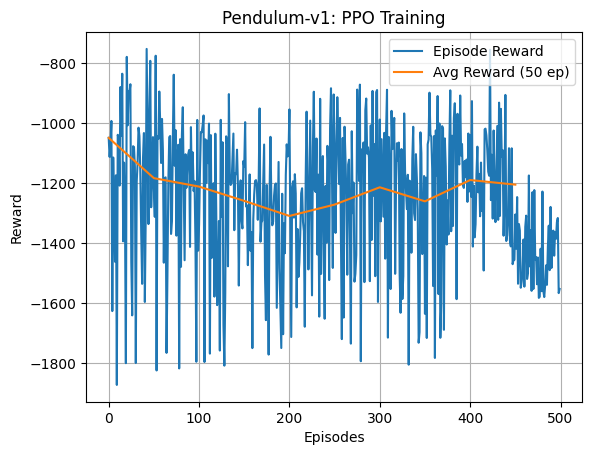

TypeError: size must be two numbers

In [54]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo

# Hyperparameters
GAMMA = 0.995
LR = 0.0002
CLIP_EPS = 0.15
EPOCHS = 2
EPISODES = 500
ENTROPY_COEF = 0.03
# PPO Actor-Critic for continuous actions
class PPOActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPOActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.actor_mean = nn.Linear(128, action_dim)
        self.actor_log_std = nn.Parameter(torch.zeros(action_dim))
        self.critic = nn.Linear(128, 1)

    def forward(self, state):
        x = self.common(state)
        mean = self.actor_mean(x)
        std = torch.exp(self.actor_log_std)
        value = self.critic(x)
        return mean, std, value

# Collect experience for one episode
def collect_trajectory(env, model):
    states, actions, log_probs, rewards, values = [], [], [], [], []
    state = env.reset()[0]
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        mean, std, value = model(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)

        clipped_action = action.detach().numpy().flatten()
        next_state, reward, terminated, truncated, _ = env.step(clipped_action)
        done = terminated or truncated

        states.append(state_tensor.squeeze(0))
        actions.append(action.squeeze(0))
        log_probs.append(log_prob)
        rewards.append(reward)
        values.append(value.squeeze(0))

        state = next_state

    return states, actions, log_probs, rewards, values

# Compute advantage and return
def compute_advantages(rewards, values, gamma=GAMMA):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns, dtype=torch.float32)
    values_tensor = torch.stack(values)

    advantages = (returns - values_tensor).detach()
    return returns, advantages

# PPO training step
def ppo_update(model, optimizer, states, actions, old_log_probs, returns, advantages):
    states = torch.stack(states)
    actions = torch.stack(actions)
    old_log_probs = torch.stack(old_log_probs).detach()
    returns = returns.detach()
    advantages = advantages.detach()

    for _ in range(EPOCHS):
        mean, std, values = model(states)
        dist = torch.distributions.Normal(mean, std)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1).mean()

        ratio = torch.exp(new_log_probs - old_log_probs)
        surrogate1 = ratio * advantages
        surrogate2 = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * advantages

        actor_loss = -torch.min(surrogate1, surrogate2).mean()
        critic_loss = (returns - values.squeeze()).pow(2).mean()
        loss = actor_loss + 0.5 * critic_loss - ENTROPY_COEF * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Train PPO
def train(env, model, optimizer, episodes):
    reward_history, avg_rewards = [], []

    for ep in range(episodes):
        states, actions, log_probs, rewards, values = collect_trajectory(env, model)
        returns, advantages = compute_advantages(rewards, values)
        ppo_update(model, optimizer, states, actions, log_probs, returns, advantages)

        ep_reward = sum(rewards)
        reward_history.append(ep_reward)

        if ep % 50 == 0:
            avg = np.mean(reward_history[-50:])
            avg_rewards.append(avg)
            print(f"Episode {ep}, Return: {ep_reward:.2f}, Avg(50): {avg:.2f}")

    return reward_history, avg_rewards

# Plotting
def plot_rewards(reward_history, avg_rewards):
    plt.plot(reward_history, label="Episode Reward")
    plt.plot(np.arange(0, len(avg_rewards) * 50, 50), avg_rewards, label="Avg Reward (50 ep)")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Pendulum-v1: PPO Training")
    plt.legend()
    plt.grid()
    plt.show()

# Run and record
def run_actor_and_record_video(env_name, model, video_dir='ppo_pendulum_video', filename='ppo_episode'):
    import os
    from pathlib import Path
    from gym.wrappers import RecordVideo

    # Create video directory
    Path(video_dir).mkdir(parents=True, exist_ok=True)

    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(
        env,
        video_folder=video_dir,
        name_prefix=filename,
        episode_trigger=lambda episode_id: True
    )

    done = False
    total_reward = 0.0
    state, _ = env.reset()
    model.eval()

    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            mean, std, _ = model(state_tensor)
            action = mean.detach().cpu().numpy()
            action = np.clip(np.atleast_1d(action), -2.0, 2.0).astype(np.float32)


        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated


    env.close()
    print(f"🎬 Recorded episode saved. Total Reward: {total_reward:.2f}")






# ---- Main ----
env_name = "Pendulum-v1"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
env.close()

model = PPOActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Train
env = gym.make(env_name)
reward_history, avg_rewards = train(env, model, optimizer, EPISODES)

# Save model
torch.save(model.state_dict(), "ppo_pendulum.pth")

# Plot results
plot_rewards(reward_history, avg_rewards)

# Run and record
run_actor_and_record_video(env_name, model)
